# NIH Chest X-ray Multi label Binary classification using Tensorflow Densenet121 (Transfer learning)


In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd


'/workspaces/chest-x-ray-diagnosis'

## Imports

In [2]:
# Set environment variables
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

2025-03-18 14:40:43.837551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742308843.852668  372351 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742308843.857410  372351 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
     raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import opendatasets as od

from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K


In [5]:
%matplotlib inline

# auto reload libs
%load_ext autoreload
%autoreload 2

## Download the dataset


In [6]:
dataset_url = 'https://www.kaggle.com/datasets/nih-chest-xrays/sample'

# Look into the data directory
datasets = 'datasets/sample'
dataset_path = Path(datasets)
IMAGE_DIR = dataset_path /'sample/images'
CSV_PATH = dataset_path /'sample/sample_labels.csv'
dataset_path.mkdir(parents=True, exist_ok=True)
if not dataset_path.is_dir():
    od.download(dataset_url)

## Paths Setup

In [7]:
from hydra import initialize, compose

# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_IMAGES_DIR)

datasets/sample/sample/images


## Constants

In [8]:
IMAGE_SIZE = cfg.TRAIN.IMG_SIZE
BATCH_SIZE = cfg.TRAIN.BATCH_SIZE
NUM_EPOCHS = cfg.TRAIN.NUM_EPOCHS
LEARNING_RATE = cfg.TRAIN.LEARNING_RATE

## Load Datasets

In [9]:
# drop_colums = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
#        'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
#        'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
# 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',

# labels =['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
#        'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
#        'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
CLASSES_NAME = ['Atelectasis','Effusion','Infiltration', 'Mass']#,'Nodule']

In [10]:
from src.data_loader.chest_x_ray_preprocessor import ChestXRayPreprocessor

preprocessor = ChestXRayPreprocessor(cfg, labels=CLASSES_NAME)
train_ds, valid_ds, pos_weights, neg_weights = preprocessor.get_training_and_validation_datasets()

2025-03-18 14:40:47,159 — src.data_loader.chest_x_ray_preprocessor — INFO — Getting training and validation datasets with batch size:None
2025-03-18 14:40:47,160 — src.data_loader.chest_x_ray_preprocessor — INFO — Loading and preprocessing dataframe
2025-03-18 14:40:47,166 — src.data_loader.chest_x_ray_preprocessor — INFO — Cleaning up training dataframe
2025-03-18 14:40:47,190 — src.data_loader.chest_x_ray_preprocessor — INFO — Loaded dataframe with shape: (5606, 2) and 5606 rows
2025-03-18 14:40:47,210 — src.data_loader.chest_x_ray_preprocessor — INFO — training split: 4484 and validation split: 1122


I0000 00:00:1742308847.140137  372351 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7067 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


2025-03-18 14:40:51,056 — src.data_loader.chest_x_ray_preprocessor — INFO — Preparing training dataset with augmentation
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2025-03-18 14:40:51,508 — src.data_loader.chest_x_ray_preprocessor — INFO — Augmenting image
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2025-03-18 14:40:52,909 — src.data_loader.chest_x_ray_preprocessor — INFO — Augmenting image
2025-03-18 14:40

In [11]:
for batch in train_ds.take(1):
    images, labels = batch
    print(images.shape, labels.shape)
    print(images[0].shape, images[0].numpy().min(), images[0].numpy().max(), labels[0])

(16, 320, 320, 1) (16, 4)
(320, 320, 1) -2.014565 1.766156 tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)


In [12]:
for batch in valid_ds.take(1):
    images, labels = batch
    print(images.shape, labels.shape)
    print(images[0].shape, images[0].numpy().min(), images[0].numpy().max(), labels[0])

(16, 320, 320, 1) (16, 4)
(320, 320, 1) -2.014565 0.94284743 tf.Tensor([0. 0. 0. 0.], shape=(4,), dtype=float32)


In [13]:
def plot_random_images(train_ds, num_images=9):
  """
  Plots a random sample of images and their corresponding labels from a TensorFlow dataset.

  Args:
    train_ds: A TensorFlow dataset object containing image-label pairs.
    num_images: The number of images to plot (default: 9).
  """

  # Ensure the dataset is shuffled (if it's not already)
  train_ds = train_ds.shuffle(buffer_size=1024)

  # Take a batch of images and labels
  _images = []
  _labels = []
  for images, labels in train_ds:
      for image, label in zip(images, labels):
        _images.append(image)
        _labels.append(label)
        if len(images) >= num_images:
            break
        
      break

  # Create a figure and axes for the plot
  plt.figure(figsize=(10, 10))

  # Iterate through the images and plot them
  for i in range(num_images):
    ax = plt.subplot(int(num_images**0.5), int(num_images**0.5), i + 1) # Create a grid of subplots
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray') # Convert to numpy and uint8 for display
    plt.title(f"Label: {labels[i].numpy()}") # Display the label
    plt.axis("off") # Hide the axes

  plt.tight_layout()
  plt.show()

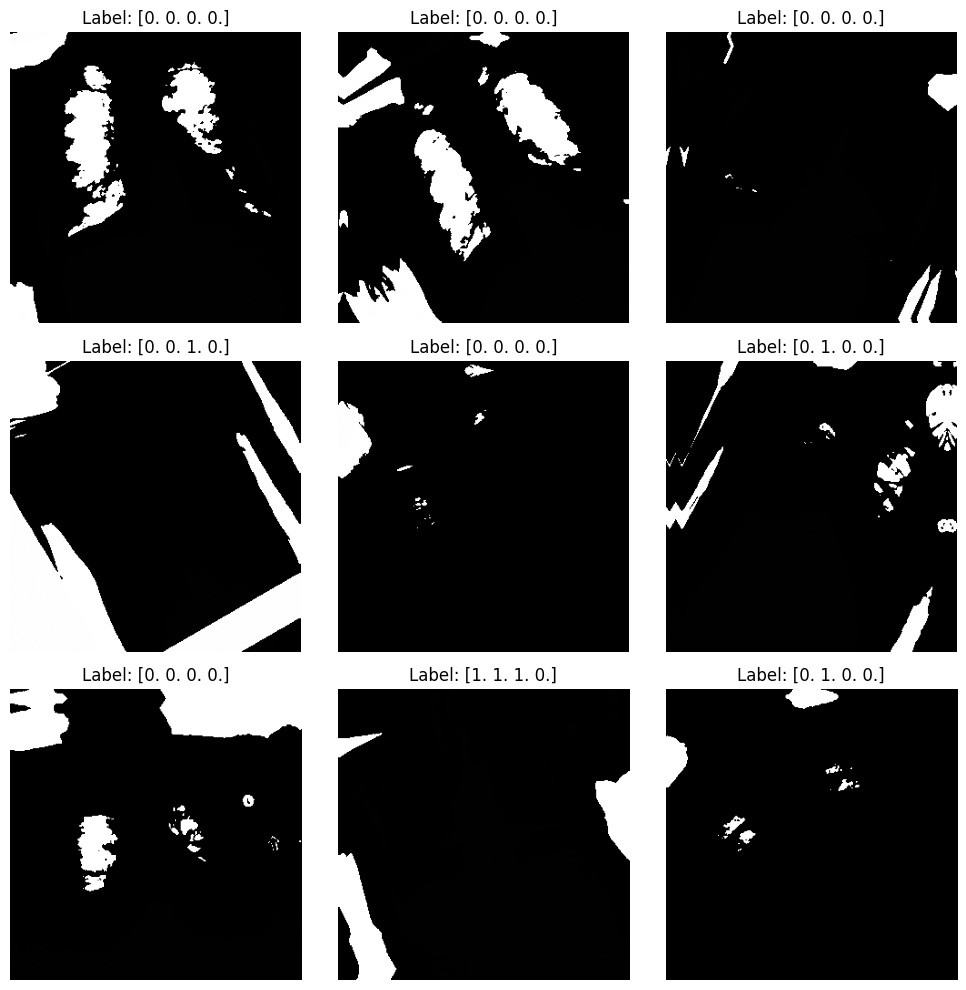

In [14]:
plot_random_images(train_ds)

#### Compute Class Frequencies

In [15]:
# N = train_cat_labels_df.shape[0]
# positive_frequencies = (train_cat_labels_df==1).sum()/N
# negative_frequencies = (train_cat_labels_df==0).sum()/N
# positive_frequencies, negative_frequencies

In [16]:
# data_df = pd.DataFrame(list(positive_frequencies.items()), columns=['class', 'positives'])
# data_df['negatives'] = negative_frequencies.values
# data_df

In [17]:
# data_df.plot.bar(x='class')

As we see in the above plot, the contributions of positive cases is significantly lower than that of the negative ones. However, we want the contributions to be equal. One way of doing this is by multiplying each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

To have this, we want 

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

which we can do simply by taking 

$$w_{pos} = freq_{neg}$$
$$w_{neg} = freq_{pos}$$

This way, we will be balancing the contribution of positive and negative labels.

In [18]:
# _pos_weights = negative_frequencies.values
# _neg_weights = positive_frequencies.values
# positive_frequencies.values

# Try adjusting the weight balance slightly
# pos_weights = np.sqrt(negative_frequencies.values) * 0.8  # Reduce positive weight slightly
# neg_weights = np.sqrt(positive_frequencies.values) * 1.2  # Increase negative weight slightly

In [19]:
# pos_contirbution = positive_frequencies * _pos_weights
# neg_contribution = negative_frequencies * _neg_weights

# pos_contirbution, neg_contribution

In [20]:
# weighted_data_df = pd.DataFrame(list(pos_contirbution.items()), columns=['class', 'positives'])
# weighted_data_df['negatives'] = neg_contribution.values
# weighted_data_df

In [21]:
# weighted_data_df.plot.bar(x='class')

## Weighted loss calculation to handle class imbalance

As the above figure shows, by applying these weightings the positive and negative labels within each class would have the same aggregate contribution to the loss function. Now let's implement such a loss function. 

After computing the weights, our final weighted loss for each training case will be 

$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [22]:
import keras
@keras.saving.register_keras_serializable()
def _get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    @keras.saving.register_keras_serializable()
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            y = y_true[:, i]
            f_of_x = y_pred[:, i]

            f_of_x_log = K.log(f_of_x + epsilon)
            f_of_x_1_min_log = K.log((1-f_of_x) + epsilon)

            first_term = pos_weights[i] * y * f_of_x_log
            sec_term = neg_weights[i] * (1-y) * f_of_x_1_min_log
            loss_per_col = - K.mean(first_term + sec_term)
            loss += loss_per_col
        return loss

    return weighted_loss



## Model Development

### Load and Prepare DenseNet121 Model

In [23]:
tf.keras.backend.clear_session()

In [24]:
import mlflow
to_monitor = 'val_AUC'
mode = 'max'
mlflow.start_run()
mlflow.tensorflow.autolog(log_models=True, 
                        log_datasets=False, 
                        log_input_examples=True,
                        log_model_signatures=True,
                        keras_model_kwargs={"save_format": "keras"},
                        checkpoint_monitor=to_monitor, 
                        checkpoint_mode=mode)

In [25]:
base_model = DenseNet121(
     include_top=False,
     weights=None, #'imagenet', 
     input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)  
)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(CLASSES_NAME), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)


In [26]:
METRICS = [
    'binary_accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='AUC'), 
]

In [29]:
from src.weighted_loss.weighted_loss import get_weighted_loss  

model.compile(optimizer=tf.keras.optimizers.AdamW(), 
               loss=get_weighted_loss(pos_weights, neg_weights),
        metrics=METRICS)     

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 326, 326, 1)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 160, 160, 64)         3136      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 160, 160, 64)         256       ['conv1/conv[0][0]']      

                                                                                                  
 conv3_block3_concat (Conca  (None, 40, 40, 224)          0         ['conv3_block2_concat[0][0]', 
 tenate)                                                             'conv3_block3_2_conv[0][0]'] 
                                                                                                  
 conv3_block4_0_bn (BatchNo  (None, 40, 40, 224)          896       ['conv3_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block4_0_relu (Activ  (None, 40, 40, 224)          0         ['conv3_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_blo

## Model training

## Callbacks

In [30]:
CHECK_POINT_DIR = 'exported_models'
checkpoint_prefix = os.path.join(CHECK_POINT_DIR, "ckpt_{epoch}.keras")
LOG_DIR = 'logs'

In [31]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                        save_best_only=True, # Save only the best model based 'to_monitor'
                                        monitor=to_monitor,
                                        mode=mode,
                                        verbose=1),  # Display checkpoint saving messages
    tf.keras.callbacks.ReduceLROnPlateau(monitor=to_monitor,
                                        mode=mode, factor=0.1, patience=5, min_lr=1e-7),
    tf.keras.callbacks.EarlyStopping(monitor=to_monitor,
                                        mode=mode, patience=10, restore_best_weights=True),
]

In [32]:
history = model.fit(train_ds, 
                    validation_data=valid_ds,
                    batch_size=cfg.TRAIN.BATCH_SIZE,
                    epochs = cfg.TRAIN.NUM_EPOCHS,
                    callbacks=callbacks)


Epoch 1/3


I0000 00:00:1742309036.393338  372481 cuda_dnn.cc:529] Loaded cuDNN version 90701
I0000 00:00:1742309039.409383  372479 service.cc:148] XLA service 0x7baf490a68c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742309039.409401  372479 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
I0000 00:00:1742309039.470948  372479 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


281/281 [==============================] - ETA: 0s - loss: 0.5328 - binary_accuracy: 0.5111 - precision: 0.1148 - recall: 0.5307 - AUC: 0.5252
Epoch 1: val_AUC improved from -inf to 0.42635, saving model to exported_models/ckpt_1.keras


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


281/281 [==============================] - 104s 155ms/step - loss: 0.5328 - binary_accuracy: 0.5111 - precision: 0.1148 - recall: 0.5307 - AUC: 0.5252 - val_loss: 0.5326 - val_binary_accuracy: 0.4220 - val_precision: 0.0913 - val_recall: 0.4906 - val_AUC: 0.4264 - lr: 0.0010
Epoch 2/3
281/281 [==============================] - ETA: 0s - loss: 0.5294 - binary_accuracy: 0.5251 - precision: 0.1189 - recall: 0.5354 - AUC: 0.5383
Epoch 2: val_AUC improved from 0.42635 to 0.43282, saving model to exported_models/ckpt_2.keras
281/281 [==============================] - 36s 126ms/step - loss: 0.5294 - binary_accuracy: 0.5251 - precision: 0.1189 - recall: 0.5354 - AUC: 0.5383 - val_loss: 3.4209 - val_binary_accuracy: 0.6408 - val_precision: 0.0719 - val_recall: 0.1975 - val_AUC: 0.4328 - lr: 0.0010
Epoch 3/3
281/281 [==============================] - ETA: 0s - loss: 0.5226 - binary_accuracy: 0.5234 - precision: 0.1202 - recall: 0.5453 - AUC: 0.5538
Epoch 3: val_AUC improved from 0.43282 to 0.548

In [33]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec
import numpy as np

# 1. Input Schema
# -----------------
# Your input is a batch of images with shape (32, 240, 240, 3)
# We use -1 to indicate that the batch size can vary.
input_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, IMAGE_SIZE, IMAGE_SIZE, 1), "image")])

# 2. Output Schema - Multilabel binary classification head
# ------------------
# Your model outputs a list of two arrays. We need to define a schema for each.
# Array 1: Shape (1, 4)
output_schema = Schema([TensorSpec(np.dtype(np.float32), (-1, len(CLASSES_NAME)), "classification")])

# 3. Model Signature
# --------------------
# Combine the input and output schemas into a ModelSignature
signature = ModelSignature(inputs=input_schema, outputs=output_schema)
mlflow.tensorflow.log_model(
    model,
    "best_model",
    signature=signature,
    code_paths=["src"],
)

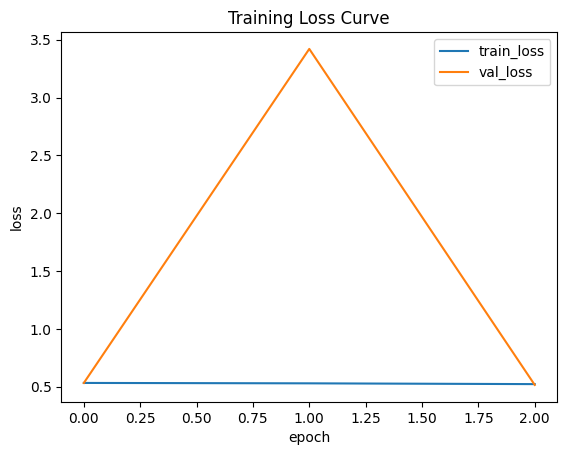

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss', 'val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.show()

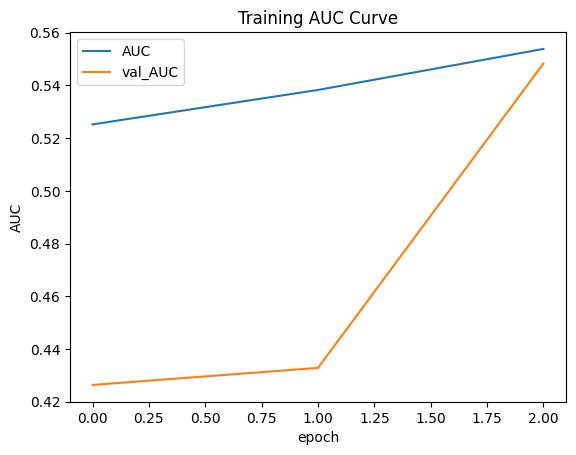

In [35]:
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.legend(['AUC', 'val_AUC'])
plt.ylabel("AUC")
plt.xlabel("epoch")
plt.title("Training AUC Curve")
plt.show()

## Model Evaluation

In [36]:
del train_ds, valid_ds

In [37]:
from src.data_loader.chest_x_ray_preprocessor import ChestXRayPreprocessor

test_prorcessor  = ChestXRayPreprocessor(cfg, labels=CLASSES_NAME)
test_ds = test_prorcessor.get_test_dataset()

2025-03-18 14:48:48,971 — src.data_loader.chest_x_ray_preprocessor — INFO — Getting test dataset
2025-03-18 14:48:49,038 — src.data_loader.chest_x_ray_preprocessor — INFO — Normalizing image
2025-03-18 14:48:49,076 — src.data_loader.chest_x_ray_preprocessor — INFO — Normalizing image


In [38]:
for batch in test_ds.take(1):
    images, labels = batch
    print(images.shape, labels.shape)
    print(images[0].shape, images[0].numpy().min(), images[0].numpy().max(), labels[0])

(16, 320, 320, 1) (16, 4)
(320, 320, 1) 0.8999634 241.05002 tf.Tensor([1. 1. 1. 0.], shape=(4,), dtype=float32)


In [39]:
result = model.evaluate(test_ds, return_dict=True, batch_size=BATCH_SIZE)
result

27/27 [==============================] - 1s 40ms/step - loss: 6.7502 - binary_accuracy: 0.3167 - precision: 0.1365 - recall: 0.7414 - AUC: 0.4950


{'loss': 6.750158309936523,
 'binary_accuracy': 0.3166666626930237,
 'precision': 0.13650794327259064,
 'recall': 0.7413793206214905,
 'AUC': 0.4949990510940552}

In [40]:
mlflow.log_metrics(result)
mlflow.end_run()
result

{'loss': 6.750158309936523,
 'binary_accuracy': 0.3166666626930237,
 'precision': 0.13650794327259064,
 'recall': 0.7413793206214905,
 'AUC': 0.4949990510940552}

In [41]:
preds = model.predict(test_ds)
preds = preds.astype(int)

27/27 [==============================] - 3s 31ms/step


In [42]:
preds

array([[0, 1, 1, 1],
       [0, 1, 1, 1],
       [0, 1, 1, 1],
       ...,
       [0, 1, 1, 1],
       [0, 1, 1, 1],
       [0, 1, 1, 1]])

In [43]:
tf_model = tf.keras.saving.load_model('exported_models/ckpt_2.keras')
tf_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 326, 326, 1)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 160, 160, 64)         3136      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 160, 160, 64)         256       ['conv1/conv[0][0]']      

In [44]:
model_uri = 'runs:/74cb397adcc642459ac5b1cd754cf74c/best_model'

model = mlflow.pyfunc.load_model(model_uri=model_uri)
